<a href="https://colab.research.google.com/github/patrickphatnguyen/Knowledge-Distillation-Keras/blob/master/Knowledge_Distillation_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distilling Knowledge in Neural Network

The term "Knowledge Distillation" (a.k.a Teacher-Student Model) was first introduced by (Bu-cilu et al., 2006; Ba & Caruana,2014) and has been popularized by (Hinton et al., 2015), as a way to let smaller deep learning models learn how bigger ones generalize to large datasets, hence increase the performance of the smaller one. In this notebook, I'll try to explain the idea of knowledge distillation alongside with hands-on implementation of it.

# The main idea


# Install and import requirements


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,Dense,Softmax,Flatten,MaxPooling2D,Dropout,Activation, Lambda, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import kullback_leibler_divergence as KLD_Loss, categorical_crossentropy as logloss
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy
import seaborn as sns

#  Load and preprocess the data

In [0]:
NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Normalize the dataset
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape each example to WIDTH*HEIGHT*CHANNELS for Convolution operation
# x_test = x_test.reshape(-1,,28,1)
# x_train = x_train.reshape(-1,28,28,1)


x_train shape: (50000, 32, 32, 3) y_train shape: (50000, 1)


# Create teacher model

In [0]:
Teacher = Sequential() # Must define the input shape in the first layer of the neural network
Teacher.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3)))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Flatten())
Teacher.add(Dense(256, activation='relu'))
Teacher.add(Dropout(0.5))
Teacher.add(Dense(10))
Teacher.add(Activation('softmax'))

Teacher.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Take a look at the model summary

Teacher.summary()

W0809 14:32:38.185163 139750472083328 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [0]:
myCP = ModelCheckpoint(save_best_only=True,filepath='teacher.h5',monitor = 'val_acc')
Teacher.fit(x_train,
         y_train,
         batch_size=128,
         epochs=20,
         validation_split = 0.2,
         callbacks=[myCP])

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 4s 112us/sample - loss: 1.6893 - acc: 0.3891 - val_loss: 1.3523 - val_acc: 0.5280
Epoch 2/20
40000/40000 [==============================] - 2s 60us/sample - loss: 1.3560 - acc: 0.5121 - val_loss: 1.2365 - val_acc: 0.5690
Epoch 3/20
40000/40000 [==============================] - 2s 60us/sample - loss: 1.2333 - acc: 0.5610 - val_loss: 1.0995 - val_acc: 0.6171
Epoch 4/20
40000/40000 [==============================] - 2s 59us/sample - loss: 1.1362 - acc: 0.5949 - val_loss: 1.1003 - val_acc: 0.6065
Epoch 5/20
40000/40000 [==============================] - 2s 59us/sample - loss: 1.0761 - acc: 0.6201 - val_loss: 1.0189 - val_acc: 0.6416
Epoch 6/20
40000/40000 [==============================] - 2s 59us/sample - loss: 1.0135 - acc: 0.6423 - val_loss: 0.9939 - val_acc: 0.6524
Epoch 7/20
40000/40000 [==============================] - 2s 59us/sample - loss: 0.9617 - acc: 0.6590 - val_loss: 0

In [0]:
# Retrieve best model from saved
Teacher = load_model('teacher.h5')

# Evaluation with test set
Teacher.evaluate(x_test,y_test)

W0809 14:33:28.917092 139750472083328 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0809 14:33:28.918682 139750472083328 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


10000/10000 [==============================] - 1s 66us/sample - loss: 0.8755 - acc: 0.7075


[0.8754792424201965, 0.7075]

# Understand temperature

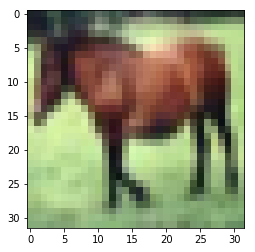

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

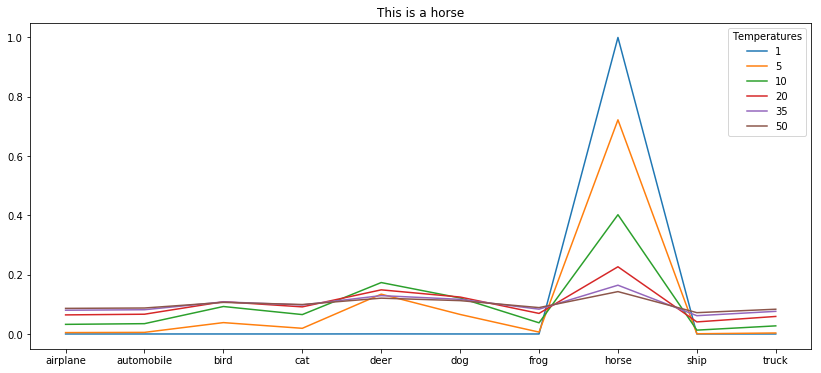

In [0]:
Teacher_logits = Model(Teacher.input,Teacher.layers[-2].output)

logits_plot = []

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]										


# Choose the item to visualize temperature
item_idx = 7

item_image = x_train[item_idx]

plt.imshow(item_image)

Temperatures = [1,5,10,20,35,50]


for Temperature in Temperatures:
  # Create temperature layer that produces logits with temperature
  T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)
  
  # Create a softmax layer
  Softmax_layer = Softmax()(T_layer)
  # Add the teacher T_layer to the whole model
  Teacher_logits_soften = Model(Teacher.input,Softmax_layer)
                             
  # Append for plotting
  logits_plot.append(Teacher_logits_soften.predict(np.array([item_image])))
  
  plt.figure(figsize=(14, 6))
for i in range(len(Temperatures)):
  sns.lineplot(class_names,logits_plot[i][0],legend="full")
  plt.title('This is a '+ class_names[y_train[item_idx][0]])
  plt.legend(Temperatures,title="Temperatures")

# Create a teacher model that create softened output
As mentioned in **Hinton's paper**:  "When the distilled net had 300 or more units in each of its two hidden layers, all temperatures above gave fairly similar results. But when this was radically reduced to 30 units per layer, temperatures in the range 2.5 to 4 worked significantly better than high or lower temperatures."  
In this notebook, I'll use temperature **3.25**, feel free to change to the Temperature to any number of your interest.

In [0]:
Temperature = 3.25
T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)
Softmax_layer = Activation('softmax')(T_layer)
Teacher_soften = Model(Teacher.input,Softmax_layer)

In [0]:
# Predict and convert to sparse categorical matrix
y_train_new = Teacher_soften.predict(x_train)
y_test_new = Teacher_soften.predict(x_test)

y_train_new = np.c_[to_categorical(y_train),y_train_new]
y_test_new = np.c_[to_categorical(y_test),y_test_new]

# Create a student model that produces with and without soften output

The student model we'll in this notebook is a really shallow neural network with only 1 hidden layers with 64 units, followed by a 10 softmax unit for the output

In [0]:
Student = Sequential() #a Must define the input shape in the first layer of the neural network
Student.add(Flatten(input_shape=(32,32,3)))
Student.add(Dense(64, activation='relu'))
Student.add(Dense(10))
Student.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                196672    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 197,322
Trainable params: 197,322
Non-trainable params: 0
_________________________________________________________________


In [0]:
student_logits = Student.layers[-1].output

# Compute softmax
probs = Activation("softmax")(student_logits)

# Compute softmax with softened logits
logits_T = Lambda(lambda x:x/Temperature)(student_logits)
probs_T = Activation("softmax")(logits_T)

CombinedLayers = concatenate([probs,probs_T])

StudentModel = Model(Student.input,CombinedLayers)

<center><img src="https://nervanasystems.github.io/distiller/imgs/knowledge_distillation.png" width=500></center>
<center> 

$$ \text{Let } a_{t}  \text{ and } a_{s} \text{ be the logits (the inputs to the final softmax) of the teacher and student network, respectively, with the ground-truth label } y_{r} .\text{ We calculate the cross-entropy between the softmax} (a_{s},y_{r}) \text{ and } y_{r} \text{ as follow:}$$
$$ \mathcal{L}_{SL}=\mathcal{H}(\text{softmax}(a_{s},y_{r})) $$

$$ \text{In knowledge distillation (in all 3 papers), we tries to match the softened outputs of the student } y_{s} = \text{softmax}(a_{s}/\mathcal{T})   \text{ and teacher's softened outputs }  y_{t}=\text{softmax}(a_{t}/\mathcal{T}) \text{via a KL-divergence loss}$$
$$\mathcal{L}_{KD}=\mathcal{T}^2\text{KL}(y_{s},y_{t})$$ 
$$ \text{The student model will then be trained on a "combined" loss between } \mathcal{L}_{SL} \text{ and } \mathcal{L}_{KD} \text{ with } \lambda \text{ representing the trade off of 2 losses }$$
$$\mathcal{L}_{\text{student}} = \lambda\mathcal{L}_{SL} + (1-\lambda)\mathcal{L}_{KD}$$

In [0]:
def KD_loss(y_true,y_pred,lambd=0.5,T=10.0):
  y_true,y_true_KD = y_true[:,:NUM_CLASSES],y_true[:,NUM_CLASSES:]
  y_pred,y_pred_KD = y_pred[:,:NUM_CLASSES],y_pred[:,NUM_CLASSES:]
  # Classic cross-entropy (without temperature)
  CE_loss = logloss(y_true,y_pred)
  # KL-Divergence loss for softened output (with temperature)
  KL_loss = T**2*KLD_Loss(y_true_KD,y_pred_KD)
  
  return lambd*CE_loss + (1-lambd)*KL_loss

def accuracy(y_true,y_pred):
  return categorical_accuracy(y_true,y_pred)
  

In [0]:
StudentModel.compile(optimizer='adam',loss=lambda y_true,y_pred: KD_loss(y_true, y_pred,lambd=0.5,T=Temperature),metrics=[accuracy])

In [0]:
myCP = ModelCheckpoint(save_best_only=True,filepath='student.h5',monitor = 'val_accuracy')

StudentModel.fit(x_train,y_train_new,epochs=50,validation_split=0.15,batch_size=128,callbacks=[myCP])

Train on 42500 samples, validate on 7500 samples
Epoch 1/50
42500/42500 [==============================] - 3s 60us/sample - loss: 3.7140 - accuracy: 0.3105 - val_loss: 3.2836 - val_accuracy: 0.3513
Epoch 2/50
42500/42500 [==============================] - 2s 44us/sample - loss: 3.2945 - accuracy: 0.3738 - val_loss: 3.1989 - val_accuracy: 0.3471
Epoch 3/50
42500/42500 [==============================] - 2s 43us/sample - loss: 3.1572 - accuracy: 0.3867 - val_loss: 3.0909 - val_accuracy: 0.3820
Epoch 4/50
42500/42500 [==============================] - 2s 42us/sample - loss: 3.0415 - accuracy: 0.4030 - val_loss: 3.3710 - val_accuracy: 0.3577
Epoch 5/50
42500/42500 [==============================] - 2s 44us/sample - loss: 2.9621 - accuracy: 0.4102 - val_loss: 3.0683 - val_accuracy: 0.3695
Epoch 6/50
42500/42500 [==============================] - 2s 44us/sample - loss: 2.8845 - accuracy: 0.4166 - val_loss: 2.8167 - val_accuracy: 0.4116
Epoch 7/50
42500/42500 [==============================] -

In [0]:
StudentModel.load_weights('student.h5')
StudentModel.evaluate(x_train,y_train_new)


50000/50000 [==============================] - 3s 64us/sample - loss: 2.3504 - accuracy: 0.4861


[2.3504372370910644, 0.4861]

# Create a standalone student

In [0]:
AloneModel = Sequential() #a Must define the input shape in the first layer of the neural netAloneStudent = Sequential() #a Must define the input shape in the first layer of the neural network
AloneModel.add(Flatten(input_shape=(32,32,3)))
AloneModel.add(Dense(64, activation='relu'))
AloneModel.add(Dense(10,activation="softmax"))
AloneModel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                196672    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                650       
Total params: 197,322
Trainable params: 197,322
Non-trainable params: 0
_________________________________________________________________


In [0]:
AloneModel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

myCP = ModelCheckpoint(_best_only=True,filepath='alone.h5',monitor = 'val_acc')

AloneModel.fit(x_train,y_train,epochs=50,validation_split=0.15,batch_size=128,callbacks=[myCP])


Train on 42500 samples, validate on 7500 samples
Epoch 1/50
42500/42500 [==============================] - 2s 52us/sample - loss: 2.0431 - acc: 0.2463 - val_loss: 1.9507 - val_acc: 0.2873
Epoch 2/50
42500/42500 [==============================] - 1s 34us/sample - loss: 1.8805 - acc: 0.3196 - val_loss: 1.9021 - val_acc: 0.3144
Epoch 3/50
42500/42500 [==============================] - 1s 34us/sample - loss: 1.8343 - acc: 0.3402 - val_loss: 1.8557 - val_acc: 0.3289
Epoch 4/50
42500/42500 [==============================] - 1s 34us/sample - loss: 1.8064 - acc: 0.3496 - val_loss: 1.8348 - val_acc: 0.3376
Epoch 5/50
42500/42500 [==============================] - 1s 35us/sample - loss: 1.7856 - acc: 0.3571 - val_loss: 1.8426 - val_acc: 0.3353
Epoch 6/50
42500/42500 [==============================] - 1s 33us/sample - loss: 1.7756 - acc: 0.3619 - val_loss: 1.8208 - val_acc: 0.3356
Epoch 7/50
42500/42500 [==============================] - 1s 33us/sample - loss: 1.7637 - acc: 0.3663 - val_loss: 1.8

In [0]:
AloneModel = load_model("alone.h5")
AloneModel.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 66us/sample - loss: 1.6973 - acc: 0.3934


[1.6973005071640015, 0.3934]

# References
[Nervanasystem github's
](https://nervanasystems.github.io/distiller/knowledge_distillation.html)

[Hinton et. al. - 
Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531)

[Seyed-Iman Mirzadeh et. al. - Improved Knowledge Distillation via Teacher Assistant:Bridging the Gap Between Student and Teacher](https://arxiv.org/abs/1902.03393)